<a href="https://colab.research.google.com/github/ShahZebYousafzai/Deep-Learning-Basics/blob/main/6_Transfer_Learning(FineTuning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer_Learning (FineTuning)

In previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning.

In [ ]:
# Check if we're using a GPU
!nvidia-smi

Tue Oct 19 09:49:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

We've done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-10-19 09:49:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-19 09:49:52 (74.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> 🔑 **Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_function.py`, so you'll have to redownload it if you want access to your helper_functions.

## Let's get some data

This time we're going to see how we can use the pretrained models with `tf.keras.applications` and apply them to our own problem (recognizing images of food.

In [ ]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2021-10-19 09:49:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.128, 108.177.120.128, 142.250.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   153MB/s    in 1.0s    

2021-10-19 09:49:56 (153 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Cehck out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [ ]:
# Create Train and test directory paths
train_dir = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [ ]:
# Check out class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch of data
for image, label in train_data_10_percent.take(1):
  print(image, label)

tf.Tensor(
[[[[7.69285736e+01 7.29285736e+01 7.19285736e+01]
   [7.75255127e+01 7.35255127e+01 7.25255127e+01]
   [8.02193909e+01 7.62193909e+01 7.52193909e+01]
   ...
   [7.60000000e+01 7.62142639e+01 7.66427917e+01]
   [7.63571396e+01 7.63571396e+01 7.63571396e+01]
   [7.59999619e+01 7.39999619e+01 7.49999619e+01]]

  [[7.90000000e+01 7.50000000e+01 7.40000000e+01]
   [7.99285736e+01 7.59285736e+01 7.49285736e+01]
   [8.28724518e+01 7.88724518e+01 7.78724518e+01]
   ...
   [7.34999542e+01 7.52856903e+01 7.49284821e+01]
   [7.51326752e+01 7.51326752e+01 7.51326752e+01]
   [7.68571472e+01 7.68571472e+01 7.68571472e+01]]

  [[8.22142868e+01 7.82142868e+01 7.67857132e+01]
   [8.49285736e+01 8.09285736e+01 7.95000000e+01]
   [8.67397995e+01 8.27397995e+01 8.13112259e+01]
   ...
   [8.20254745e+01 8.38112106e+01 8.34540024e+01]
   [8.05561066e+01 8.09846802e+01 8.07703934e+01]
   [7.64999313e+01 7.69285049e+01 7.67142181e+01]]

  ...

  [[1.41352005e+02 1.49352005e+02 1.52352005e+02]
   [1

In this notebook, we will be doing a lot of experiments. These are mentioned below.

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-qxxr{background-color:#FFF;border-color:inherit;font-size:16px;text-align:center;vertical-align:top}
.tg .tg-bn4o{font-size:18px;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-qv16{font-size:16px;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-gmla{border-color:inherit;font-size:16px;text-align:center;vertical-align:top}
.tg .tg-a41q{background-color:#FFF;border-color:inherit;font-size:18px;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-2xbj{border-color:inherit;font-size:18px;font-weight:bold;text-align:center;vertical-align:top}
.tg .tg-lvth{font-size:16px;text-align:center;vertical-align:top}
.tg .tg-rwiu{background-color:#FFF;font-size:16px;text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-a41q">Experiment</th>
    <th class="tg-a41q">Data</th>
    <th class="tg-2xbj">Preprocessing</th>
    <th class="tg-bn4o">Model</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-qxxr">Model 0 (baseline)</td>
    <td class="tg-qxxr">10 classes of Food101 (<span style="font-weight:bold">random 10%</span><br><span style="font-weight:normal">training data only)</span></td>
    <td class="tg-gmla">None</td>
    <td class="tg-lvth"><span style="font-weight:bold">Feature Extractor: </span>EfficientNetB0<br>(pre-trained on ImageNet, all layers<br>frozen) with no top</td>
  </tr>
  <tr>
    <td class="tg-gmla">Model 1</td>
    <td class="tg-qxxr">10 classes of Food101 (<span style="font-weight:bold">random 1%</span><br><span style="font-weight:normal">training data only)</span></td>
    <td class="tg-gmla">Random Flip, Rotation,<br>Zoom, Height, Width,<br>data augmentation</td>
    <td class="tg-lvth">Same as Model 0</td>
  </tr>
  <tr>
    <td class="tg-qxxr">Model 2</td>
    <td class="tg-qxxr">Same as Model 0</td>
    <td class="tg-gmla">Same as Model 1</td>
    <td class="tg-lvth">Same as Model 0</td>
  </tr>
  <tr>
    <td class="tg-rwiu">Model 3</td>
    <td class="tg-lvth">Same as Model 0</td>
    <td class="tg-lvth">Same as Model 1</td>
    <td class="tg-qv16">Fine Tuning: <span style="font-weight:normal">Model 2 (EfficientNetB0</span><br><span style="font-weight:normal">pre-trained on ImageNet) </span><span style="font-weight:bold">with top</span><br><span style="font-weight:bold">layer trained on custom data, top 10</span><br><span style="font-weight:bold">layers unfrozen </span></td>
  </tr>
  <tr>
    <td class="tg-rwiu">Model 4</td>
    <td class="tg-lvth">10 classes of Food101 data (<span style="font-weight:bold">100%</span><span style="font-weight:normal"> training</span><br><span style="font-weight:normal">data)</span></td>
    <td class="tg-lvth">Same as Model 1</td>
    <td class="tg-lvth">Same as Model 3</td>
  </tr>
</tbody>
</table>

In previous notebooks, we used a lot of Keras's **[Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)**. But this time we will be using **[Functional API](https://www.tensorflow.org/guide/keras/functional)** which is more flexible and able to produce more sophisticated models.

> 🔑 **Note:** The compiling, fitting and evaluation method for Functional API is the same as Sequential API.

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models.

In [ ]:
# 1. Create the base model with tf.keras.model.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)  # We don't want to include to top layer b/c we want to add
                                                                      # our own dense layer for output layer

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

16719872/16705208 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20211019-095009
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 48s 474ms/step - loss: 1.9272 - accuracy: 0.3813 - val_loss: 1.3628 - val_accuracy: 0.7039
Epoch 2/5
24/24 [==============================] - 7s 263ms/step - loss: 1.1628 - accuracy: 0.7427 - val_loss: 0.8724 - val_accuracy: 0.8322
Epoch 3/5
24/24 [==============================] - 9s 356ms/step - loss: 0.8630 - accuracy: 0.8013 - val_loss: 0.7180 - val_accuracy: 0.8454
Epoch 4/5
24/24 [==============================] - 7s 262ms/step - loss: 0.7023 - accuracy: 0.8307 - val_loss: 0.6357 - val_accuracy: 0.8635
Epoch 5/5
24/24 [==============================] - 7s 261ms/step - loss: 0.5999 - accuracy: 0.8600 - val_loss: 0.5526 - val_accuracy: 0.8750


In [ ]:
# Evaluate on the full test dataset
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 11s 134ms/step - loss: 0.6093 - accuracy: 0.8420


[0.6093438863754272, 0.8420000076293945]

In [ ]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [ ]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [ ]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


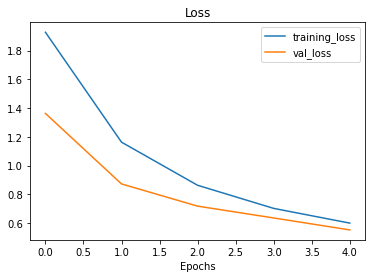

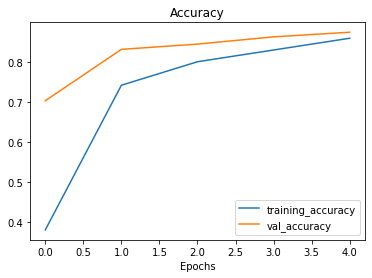

In [ ]:
# Check out model's training curves
plot_loss_curves(history_10_percent)

Our model has given a good accuracy and if we train it for more epochs we might even get better accuracy.

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor shape:\n {input_tensor.shape}\n")
print(f"Random input tensor:\n {input_tensor}\n")

# Pass random tensor through AverageGlobalPooling2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"Shape after AverageGlobalPooling2D:\n{global_average_pooled_tensor.shape}\n")
print(f"Tensors after AverageGlobalPooling2D:\n{global_average_pooled_tensor}\n")

Random input tensor shape:
 (1, 4, 4, 3)

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

Shape after AverageGlobalPooling2D:
(1, 3)

Tensors after AverageGlobalPooling2D:
[[-0.09368646 -0.45840448 -0.2885598 ]]



What `GlobalAveragePooling2D` layer does is condenses it into scaller vector which is then the input to our final dense layer i.e. output layer.

In [ ]:
# Let's replicate the GlobalAveragePool 2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

We've got the same results by using [`tf.reduce_mean`](https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean).

> 🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is because what happens is pretrained model outputs a **feature vector** (a long tensor of numbers which represents  the learned representation of the model in a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract patterns out for our own specific problem. 

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with 10% of the training data, but how about we go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> 🔑 **Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

### Getting and preprocessing data for model_1

In [ ]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2021-10-19 09:51:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.128.128, 142.251.6.128, 74.125.70.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   147MB/s    in 0.9s    

2021-10-19 09:51:46 (147 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Create training and test directories
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent  = "10_food_classes_1_percent/test"

In [ ]:
# How many image we are working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'

In [45]:
# Setup data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

We can see the benifits of doing this within the TensorFlow Data Augmentation documentation: https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing

Off the top of our heads, after reading the docs, the benifits of using data augmentation inside the model are:
* Preprocessing of image (aumenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere. But during inference (testing), augmenation does not happen.

In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms etc
data_augmentation = keras.Sequential([
                                     preprocessing.RandomFlip("horizontal"),
                                     preprocessing.RandomRotation(0.2),
                                     preprocessing.RandomZoom(0.2),
                                     preprocessing.RandomHeight(0.2),
                                     preprocessing.RandomWidth(0.2),
                                    #  preprocessing.Rescaling(1./255)  # Keep for models like ResNet50V2 but EfficientNet's having rescaling built-in
], name="data_augmentation0")

### Visualize our data augmentation layer (see what happens to our data)

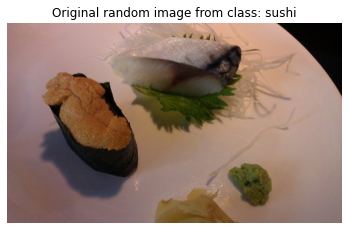

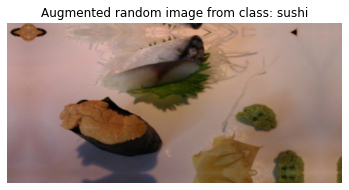

In [47]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented data
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model 1: Feature Extraction transfer learning on 1% of the data with augmentation

In [51]:
# Setup the input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data_1_percent,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_laerning",
                                                                        experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_laerning/1_percent_data_aug/20211019-105239
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 14s 3s/step - loss: 2.4270 - accuracy: 0.1143 - val_loss: 2.2920 - val_accuracy: 0.1776
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1924 - accuracy: 0.1857 - val_loss: 2.1845 - val_accuracy: 0.2155
Epoch 3/5
3/3 [==============================] - 7s 3s/step - loss: 1.9725 - accuracy: 0.3286 - val_loss: 2.0878 - val_accuracy: 0.2928
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.8394 - accuracy: 0.4000 - val_loss: 1.9961 - val_accuracy: 0.3388
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.6771 - accuracy: 0.6143 - val_loss: 1.8956 - val_accuracy: 0.4013


In [52]:
# Check out a model summary
model_1.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation0 (Sequenti (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [53]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 11s 130ms/step - loss: 1.9001 - accuracy: 0.4000


[1.9000781774520874, 0.4000000059604645]

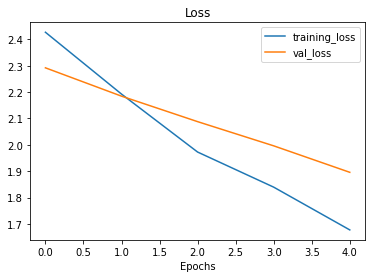

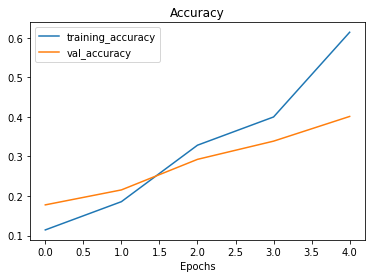

In [55]:
# How do the model with 1% of the data and dataaugmented data loss curve look like
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning with 10% of data and data augmentation

In [60]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [61]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE=(224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [62]:
# How many images are in our directories
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [68]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = keras.Sequential([
                                     preprocessing.RandomFlip("horizontal"),
                                     preprocessing.RandomRotation(0.2),
                                     preprocessing.RandomZoom(0.2),
                                     preprocessing.RandomHeight(0.2),
                                     preprocessing.RandomWidth(0.2),
                                    #  preprocessing.Rescaling(1./255)  # Keep for models like ResNet50V2 but EfficientNet's having rescaling built-in
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and the outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # augment our training images (audmentation does not occur on test data)
x = base_model(x, training=False) # pass the augmented image to the base model but keep base model in inference mode, this also insures batch_norm layers don't get updated
x = layers.GlobalAvgPool2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

### Creating a ModelCheckpoints callbacks

The [ModelCheckpoint callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) intermediately saves our model (the full model or just the weights) during training. This is useful so we cam come and start where we left off.

In [70]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that save the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", # Save every epoch
                                                         verbose=1)

### Fit model 2 passing in the ModelCheckpoint callback

In [71]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=5,
                                          steps_per_epoch=len(train_data_10_percent),
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                 experiment_name="10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20211019-113802
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 26s 759ms/step - loss: 2.0580 - accuracy: 0.2960 - val_loss: 1.5433 - val_accuracy: 0.6201

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 14s 570ms/step - loss: 1.3995 - accuracy: 0.6347 - val_loss: 1.0835 - val_accuracy: 0.7549

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 15s 616ms/step - loss: 1.0818 - accuracy: 0.7213 - val_loss: 0.8993 - val_accuracy: 0.7911

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 13s 533ms/step - loss: 0.9233 - accuracy: 0.7600 - val_loss: 0.7935 - val_accuracy: 0.8059

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 13s 518ms/step - loss: 0.8045 - accuracy: 0.7960 - val_

In [75]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 11s 130ms/step - loss: 0.6093 - accuracy: 0.8420


[0.6093438267707825, 0.8420000076293945]

In [73]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 11s 130ms/step - loss: 0.7107 - accuracy: 0.8088


[0.7107070088386536, 0.8087999820709229]

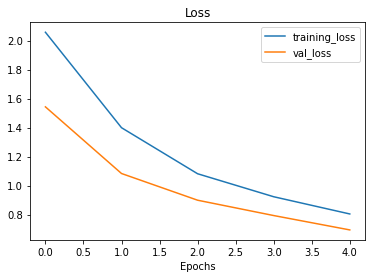

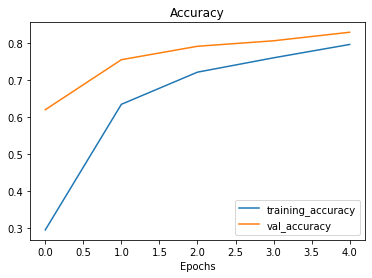

In [74]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in a checkpointed weights returns a model to a specific checkpoint

In [76]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [77]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 11s 130ms/step - loss: 0.7107 - accuracy: 0.8088


In [79]:
# If the results from our native model and the loaded weights are the same, this should output True
results_10_percent_data_aug == loaded_weights_model_results

True

Sometimes it's not True as value can be in different decimal points

In [80]:
results_10_percent_data_aug

[0.7107070088386536, 0.8087999820709229]

In [81]:
loaded_weights_model_results

[0.7107070088386536, 0.8087999820709229]

In [82]:
# Check to see if loaded model results are very close to native model results (should output True)
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [83]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[0. 0.]
